In [1]:
# -*- coding: utf-8 -*-

"""
TFI Trotter Circuit Analysis with IBM Eagle Topology

This example demonstrates how to create a TFI (Transverse Field Ising) Trotter circuit
using the IBM Eagle topology with 127 qubits and analyze it with Pauli propagation.
"""

import numpy as np
from qiskit.quantum_info import Pauli, Statevector

# Custom package imports  
from pauli_propagation import PauliTerm, PauliPropagator
from pauli_propagation.utils import encode_pauli
from pauli_propagation.circuit_topologies import tfi_trotter_circuit

# Standard library imports
import logging
import time
import json
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, Statevector
from qiskit.circuit.library import UnitaryGate
from qiskit.synthesis import TwoQubitWeylDecomposition

# Custom package imports
from pauli_propagation import PauliTerm, PauliPropagator
from pauli_propagation.utils import encode_pauli, random_su4
from pauli_propagation.gates import QuantumGate
from pauli_propagation.monte_carlo import MonteCarlo
from pauli_propagation import staircasetopology2d_qc
from pauli_propagation.decomposition import su4_kak_reconstruct, su4_kak_decomp


# Configure logging
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

In [2]:
nq = 127  # IBM Eagle has 127 qubits
nl = 10    # 5 layers

qc_tfi = tfi_trotter_circuit(nq, nl)

pauli_label = "I" * 64 + "Z" + "I" * 62  # 62 I's + 1 Z + 64 I's = 127 total
key = encode_pauli(Pauli(pauli_label))
init_term = PauliTerm(1.0, key, nq)

product_label = "0" * nq

prop_tfi = PauliPropagator(qc_tfi)

max_weight = 4

layers_tfi = prop_tfi.propagate(init_term, max_weight=max_weight, return_history=False, use_parallel=False)

exp_tfi = prop_tfi.expectation_pauli_sum(layers_tfi, product_label)

print(exp_tfi)

# nl = 20, weight = 4, time: 

Propagating (final only), max weight: 4:   0%|          | 0/2710 [00:00<?, ?it/s]

0.007312986594896461


In [3]:
# Define parameters
L_vals = [50] # e.g., [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
M = 10000 * 18 
nq = 127
max_kk = 6

# Output directory for JSON files
out_dir_tfi = os.path.join("results", "tfi")
os.makedirs(out_dir_tfi, exist_ok=True)

for L in L_vals:
    # === 0) Build the TFI Trotter circuit & initial Pauli term ===
    qc_tfi = tfi_trotter_circuit(nq, L)
    n = qc_tfi.num_qubits

    pauli_label = "I" * 64 + "Z" + "I" * 62
    key = encode_pauli(Pauli(pauli_label))
    init_term = PauliTerm(1.0, key, n)
    product_label = "0" * n
    prop_2d = PauliPropagator(qc_tfi)

    # === 1) Single Monte Carlo sampling run (shared across all k) ===
    mc = MonteCarlo(qc_tfi)
    _, _, last_weights, _ = mc.monte_carlo_samples(init_term=init_term, M=M)

    # === 2) Compute weight histogram (counts and normalized density) ===
    bins = np.arange(0.5, n + 1.5)
    hist_counts, bin_edges = np.histogram(last_weights, bins=bins, density=False)
    hist_vals = hist_counts / float(len(last_weights))

    # === 3) Estimate MC MSE for all k at once (cumulative and per‐layer) ===
    mse_mc_results_dict = mc.estimate_mse_for_truncation(propagator=prop_2d,
                                                         product_label=product_label)
    cum = mse_mc_results_dict['cumulative']
    layer = mse_mc_results_dict['layer']

    # === 4) Package results for this L into a dictionary ===
    result_for_L = {"L": L,
                    "weight_hist": {"hist_vals": hist_vals.tolist(),
                                    "bin_edges": bin_edges.tolist(),
                                    "hist_counts": hist_counts.tolist()},
                    "cum_mse":     {str(k): float(cum.get(k, 0.0))   for k in range(max_kk + 1)},
                    "weight_mse":  {str(k): float(layer.get(k, 0.0)) for k in range(max_kk + 1)}}

    # === 5) Write out JSON file with L in filename ===
    filename = os.path.join(out_dir_tfi, f"tfi_mc_results_L{L}.json")
    with open(filename, 'w') as f:
        json.dump(result_for_L, f, indent=2, ensure_ascii=False)

    print(f"Completed MC sampling for L={L}, results saved to: {filename}")

# L= 1， M= 10000*10, time: 1min37s
# L = 1, M = 50000*10, time:

MC sampling:   0%|          | 0/24 [00:00<?, ?it/s]

C:\Users\woyao\Desktop\Cambridge\ym432\pauli_pkg\pauli_propagation\monte_carlo.py:281: RuntimeWarning: overflow encountered in scalar power
  coeff_sqs = [np.abs(pauli.coeff)**2 for pauli in sampled_last_paulis]


Completed MC sampling for L=50, results saved to: results\tfi\tfi_mc_results_L50.json


In [ ]:
# Define parameters
L_vals = [50] # e.g., [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
M = 10000 * 18 
nq = 127
max_kk = 6

# Output directory for JSON files
out_dir_tfi = os.path.join("results", "tfi")
os.makedirs(out_dir_tfi, exist_ok=True)

for L in L_vals:
    # === 0) Build the TFI Trotter circuit & initial Pauli term ===
    qc_tfi = tfi_trotter_circuit(nq, L)
    n = qc_tfi.num_qubits

    pauli_label = "I" * 64 + "Z" + "I" * 62
    key = encode_pauli(Pauli(pauli_label))
    init_term = PauliTerm(1.0, key, n)
    product_label = "0" * n
    prop_2d = PauliPropagator(qc_tfi)

    # === 1) Single Monte Carlo sampling run (shared across all k) ===
    mc = MonteCarlo(qc_tfi)
    _, _, last_weights, _ = mc.monte_carlo_samples(init_term=init_term, M=M)

    # === 2) Compute weight histogram (counts and normalized density) ===
    bins = np.arange(0.5, n + 1.5)
    hist_counts, bin_edges = np.histogram(last_weights, bins=bins, density=False)
    hist_vals = hist_counts / float(len(last_weights))

    # === 3) Estimate MC MSE for all k at once (cumulative and per‐layer) ===
    mse_mc_results_dict = mc.estimate_mse_for_truncation(propagator=prop_2d,
                                                         product_label=product_label)
    cum = mse_mc_results_dict['cumulative']
    layer = mse_mc_results_dict['layer']

    # === 4) Package results for this L into a dictionary ===
    result_for_L = {"L": L,
                    "weight_hist": {"hist_vals": hist_vals.tolist(),
                                    "bin_edges": bin_edges.tolist(),
                                    "hist_counts": hist_counts.tolist()},
                    "cum_mse":     {str(k): float(cum.get(k, 0.0))   for k in range(max_kk + 1)},
                    "weight_mse":  {str(k): float(layer.get(k, 0.0)) for k in range(max_kk + 1)}}

    # === 5) Write out JSON file with L in filename ===
    filename = os.path.join(out_dir_tfi, f"tfi_mc_results_L{L}.json")
    with open(filename, 'w') as f:
        json.dump(result_for_L, f, indent=2, ensure_ascii=False)

    print(f"Completed MC sampling for L={L}, results saved to: {filename}")

# L= 1， M= 10000*10, time: 1min37s
# L = 1, M = 50000*10, time:

MC sampling:   0%|          | 0/24 [00:00<?, ?it/s]

C:\Users\woyao\Desktop\Cambridge\ym432\pauli_pkg\pauli_propagation\monte_carlo.py:281: RuntimeWarning: overflow encountered in scalar power
  coeff_sqs = [np.abs(pauli.coeff)**2 for pauli in sampled_last_paulis]


Completed MC sampling for L=50, results saved to: results\tfi\tfi_mc_results_L50.json


In [ ]:
# Define parameters
L_vals = [50] # e.g., [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
M = 10000 * 18 
nq = 127
max_kk = 6

# Output directory for JSON files
out_dir_tfi = os.path.join("results", "tfi")
os.makedirs(out_dir_tfi, exist_ok=True)

for L in L_vals:
    # === 0) Build the TFI Trotter circuit & initial Pauli term ===
    qc_tfi = tfi_trotter_circuit(nq, L)
    n = qc_tfi.num_qubits

    pauli_label = "I" * 64 + "Z" + "I" * 62
    key = encode_pauli(Pauli(pauli_label))
    init_term = PauliTerm(1.0, key, n)
    product_label = "0" * n
    prop_2d = PauliPropagator(qc_tfi)

    # === 1) Single Monte Carlo sampling run (shared across all k) ===
    mc = MonteCarlo(qc_tfi)
    _, _, last_weights, _ = mc.monte_carlo_samples(init_term=init_term, M=M)

    # === 2) Compute weight histogram (counts and normalized density) ===
    bins = np.arange(0.5, n + 1.5)
    hist_counts, bin_edges = np.histogram(last_weights, bins=bins, density=False)
    hist_vals = hist_counts / float(len(last_weights))

    # === 3) Estimate MC MSE for all k at once (cumulative and per‐layer) ===
    mse_mc_results_dict = mc.estimate_mse_for_truncation(propagator=prop_2d,
                                                         product_label=product_label)
    cum = mse_mc_results_dict['cumulative']
    layer = mse_mc_results_dict['layer']

    # === 4) Package results for this L into a dictionary ===
    result_for_L = {"L": L,
                    "weight_hist": {"hist_vals": hist_vals.tolist(),
                                    "bin_edges": bin_edges.tolist(),
                                    "hist_counts": hist_counts.tolist()},
                    "cum_mse":     {str(k): float(cum.get(k, 0.0))   for k in range(max_kk + 1)},
                    "weight_mse":  {str(k): float(layer.get(k, 0.0)) for k in range(max_kk + 1)}}

    # === 5) Write out JSON file with L in filename ===
    filename = os.path.join(out_dir_tfi, f"tfi_mc_results_L{L}.json")
    with open(filename, 'w') as f:
        json.dump(result_for_L, f, indent=2, ensure_ascii=False)

    print(f"Completed MC sampling for L={L}, results saved to: {filename}")

# L= 1， M= 10000*10, time: 1min37s
# L = 1, M = 50000*10, time:

MC sampling:   0%|          | 0/24 [00:00<?, ?it/s]

C:\Users\woyao\Desktop\Cambridge\ym432\pauli_pkg\pauli_propagation\monte_carlo.py:281: RuntimeWarning: overflow encountered in scalar power
  coeff_sqs = [np.abs(pauli.coeff)**2 for pauli in sampled_last_paulis]


Completed MC sampling for L=50, results saved to: results\tfi\tfi_mc_results_L50.json


In [ ]:
# Define parameters
L_vals = [50] # e.g., [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
M = 10000 * 18 
nq = 127
max_kk = 6

# Output directory for JSON files
out_dir_tfi = os.path.join("results", "tfi")
os.makedirs(out_dir_tfi, exist_ok=True)

for L in L_vals:
    # === 0) Build the TFI Trotter circuit & initial Pauli term ===
    qc_tfi = tfi_trotter_circuit(nq, L)
    n = qc_tfi.num_qubits

    pauli_label = "I" * 64 + "Z" + "I" * 62
    key = encode_pauli(Pauli(pauli_label))
    init_term = PauliTerm(1.0, key, n)
    product_label = "0" * n
    prop_2d = PauliPropagator(qc_tfi)

    # === 1) Single Monte Carlo sampling run (shared across all k) ===
    mc = MonteCarlo(qc_tfi)
    _, _, last_weights, _ = mc.monte_carlo_samples(init_term=init_term, M=M)

    # === 2) Compute weight histogram (counts and normalized density) ===
    bins = np.arange(0.5, n + 1.5)
    hist_counts, bin_edges = np.histogram(last_weights, bins=bins, density=False)
    hist_vals = hist_counts / float(len(last_weights))

    # === 3) Estimate MC MSE for all k at once (cumulative and per‐layer) ===
    mse_mc_results_dict = mc.estimate_mse_for_truncation(propagator=prop_2d,
                                                         product_label=product_label)
    cum = mse_mc_results_dict['cumulative']
    layer = mse_mc_results_dict['layer']

    # === 4) Package results for this L into a dictionary ===
    result_for_L = {"L": L,
                    "weight_hist": {"hist_vals": hist_vals.tolist(),
                                    "bin_edges": bin_edges.tolist(),
                                    "hist_counts": hist_counts.tolist()},
                    "cum_mse":     {str(k): float(cum.get(k, 0.0))   for k in range(max_kk + 1)},
                    "weight_mse":  {str(k): float(layer.get(k, 0.0)) for k in range(max_kk + 1)}}

    # === 5) Write out JSON file with L in filename ===
    filename = os.path.join(out_dir_tfi, f"tfi_mc_results_L{L}.json")
    with open(filename, 'w') as f:
        json.dump(result_for_L, f, indent=2, ensure_ascii=False)

    print(f"Completed MC sampling for L={L}, results saved to: {filename}")

# L= 1， M= 10000*10, time: 1min37s
# L = 1, M = 50000*10, time:

MC sampling:   0%|          | 0/24 [00:00<?, ?it/s]

C:\Users\woyao\Desktop\Cambridge\ym432\pauli_pkg\pauli_propagation\monte_carlo.py:281: RuntimeWarning: overflow encountered in scalar power
  coeff_sqs = [np.abs(pauli.coeff)**2 for pauli in sampled_last_paulis]


Completed MC sampling for L=50, results saved to: results\tfi\tfi_mc_results_L50.json


In [ ]:
# Define parameters
L_vals = [50] # e.g., [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
M = 10000 * 18 
nq = 127
max_kk = 6

# Output directory for JSON files
out_dir_tfi = os.path.join("results", "tfi")
os.makedirs(out_dir_tfi, exist_ok=True)

for L in L_vals:
    # === 0) Build the TFI Trotter circuit & initial Pauli term ===
    qc_tfi = tfi_trotter_circuit(nq, L)
    n = qc_tfi.num_qubits

    pauli_label = "I" * 64 + "Z" + "I" * 62
    key = encode_pauli(Pauli(pauli_label))
    init_term = PauliTerm(1.0, key, n)
    product_label = "0" * n
    prop_2d = PauliPropagator(qc_tfi)

    # === 1) Single Monte Carlo sampling run (shared across all k) ===
    mc = MonteCarlo(qc_tfi)
    _, _, last_weights, _ = mc.monte_carlo_samples(init_term=init_term, M=M)

    # === 2) Compute weight histogram (counts and normalized density) ===
    bins = np.arange(0.5, n + 1.5)
    hist_counts, bin_edges = np.histogram(last_weights, bins=bins, density=False)
    hist_vals = hist_counts / float(len(last_weights))

    # === 3) Estimate MC MSE for all k at once (cumulative and per‐layer) ===
    mse_mc_results_dict = mc.estimate_mse_for_truncation(propagator=prop_2d,
                                                         product_label=product_label)
    cum = mse_mc_results_dict['cumulative']
    layer = mse_mc_results_dict['layer']

    # === 4) Package results for this L into a dictionary ===
    result_for_L = {"L": L,
                    "weight_hist": {"hist_vals": hist_vals.tolist(),
                                    "bin_edges": bin_edges.tolist(),
                                    "hist_counts": hist_counts.tolist()},
                    "cum_mse":     {str(k): float(cum.get(k, 0.0))   for k in range(max_kk + 1)},
                    "weight_mse":  {str(k): float(layer.get(k, 0.0)) for k in range(max_kk + 1)}}

    # === 5) Write out JSON file with L in filename ===
    filename = os.path.join(out_dir_tfi, f"tfi_mc_results_L{L}.json")
    with open(filename, 'w') as f:
        json.dump(result_for_L, f, indent=2, ensure_ascii=False)

    print(f"Completed MC sampling for L={L}, results saved to: {filename}")

# L= 1， M= 10000*10, time: 1min37s
# L = 1, M = 50000*10, time:

MC sampling:   0%|          | 0/24 [00:00<?, ?it/s]

C:\Users\woyao\Desktop\Cambridge\ym432\pauli_pkg\pauli_propagation\monte_carlo.py:281: RuntimeWarning: overflow encountered in scalar power
  coeff_sqs = [np.abs(pauli.coeff)**2 for pauli in sampled_last_paulis]


Completed MC sampling for L=50, results saved to: results\tfi\tfi_mc_results_L50.json


In [8]:
L_vals = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

mc_results_dict = {"weight_mse":  { str(k): [] for k in range(max_kk + 1) },
                   "cum_mse":     { str(k): [] for k in range(max_kk + 1) },
                   "weight_hist": {}}

# 3) 对每个 L，打开对应的 JSON 文件，把数据载入并追加到 mc_results_dict

for L in L_vals:
    filename = os.path.join(out_dir_tfi, f"tfi_mc_results_L{L}.json")
    with open(filename, "r") as f:
        data_L = json.load(f)

    # a) 把单层 ΔMSE (weight_mse) 和 累计 MSE (cum_mse) 追加到各自列表里
    #    注意：JSON 里键是字符串 "0","1",…，我们这里保持一致
    for k in range(max_kk + 1):
        mc_results_dict["weight_mse"][str(k)].append(data_L["weight_mse"][str(k)])
        mc_results_dict["cum_mse"][str(k)].append(data_L["cum_mse"][str(k)])

    # b) 把直方图 “weight_hist” 也存进去：直接用 L 的字符串作为键，
    #    值仍然是一个包含 hist_vals/list 和 bin_edges/list 的 dict
    mc_results_dict["weight_hist"][str(L)] = data_L["weight_hist"]


[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0007222222222222222, 0.0, 0.0009944444444444445, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 1.1111111111111112e-05, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]


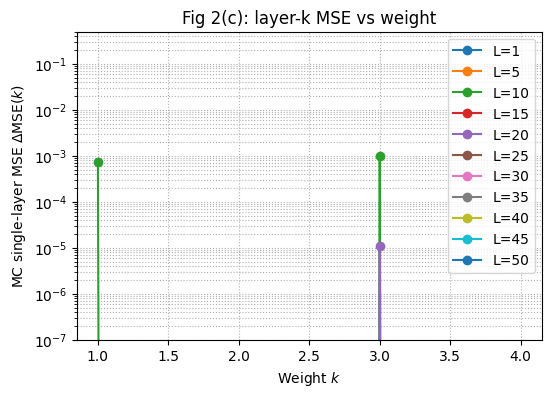

In [9]:
# —— 单层 ΔMSE vs weight (Fig 2c) —— 
plt.figure(figsize=(6,4))
for L in L_vals:
    kk_vals = list(range(1,5))
    ys = [mc_results_dict['weight_mse'][f"{kk}"][L_vals.index(L)] for kk in kk_vals]
    print(ys)
    plt.plot(kk_vals, ys, marker='o', label=f'L={L}')
plt.yscale('log')
plt.ylim(1e-7,5e-1)  # 设置 y 轴最小值为 10e-8
plt.xlabel('Weight $k$')
plt.ylabel('MC single-layer MSE $\\Delta\\mathrm{MSE}(k)$')
plt.title('Fig 2(c): layer-k MSE vs weight')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.show()


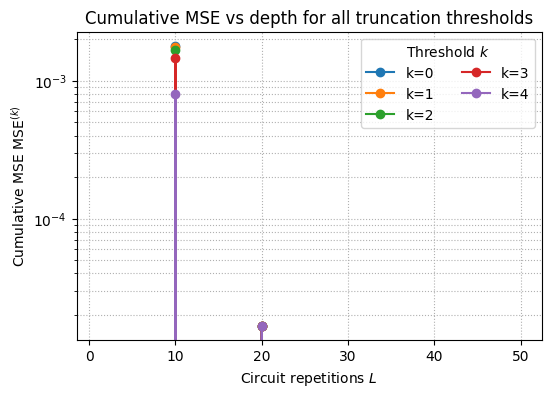

In [10]:
# —— cumulative MSE vs circuit repetitions for all kk from 0 to max_kk —— 
plt.figure(figsize=(6, 4))
for kk in range(0,5):
    ys = mc_results_dict['cum_mse'][f"{kk}"]   # list of length len(L_vals)
    plt.plot(L_vals, ys, marker='o', label=f'k={kk}')
plt.yscale('log')
plt.xlabel('Circuit repetitions $L$')
plt.ylabel('Cumulative MSE $\\mathrm{MSE}^{(k)}$')
plt.title('Cumulative MSE vs depth for all truncation thresholds')
plt.legend(title='Threshold $k$', ncol=2)
plt.grid(True, which='both', ls=':')
plt.show()


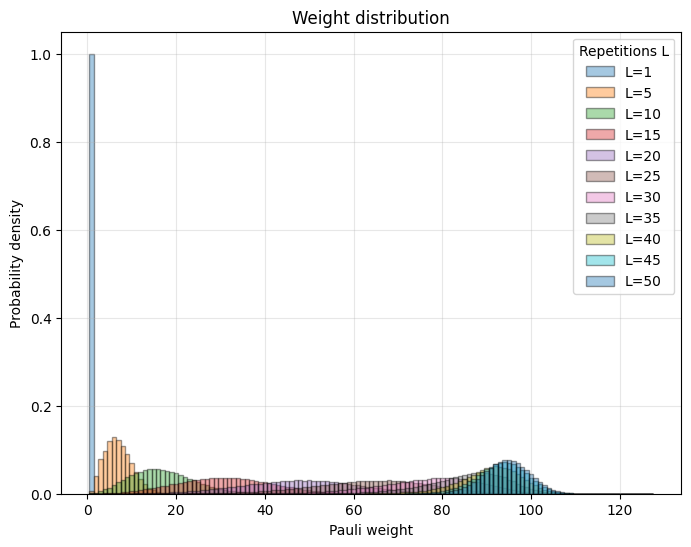

In [11]:
plt.figure(figsize=(8,6))

for L in L_vals:
    entry     = mc_results_dict['weight_hist'][str(L)]  # 注意用 str(L) 或者你已转换成 int 的 key
    hist_vals = entry['hist_vals']    # 已经是 float 列表
    bin_edges = entry['bin_edges']    # 已经是 float 列表，长度 = len(hist_vals)+1

    # 推荐用 zip 来计算每对相邻边界的差值
    widths = [b2 - b1 for b1, b2 in zip(bin_edges[:-1], bin_edges[1:])]

    # 画条形图
    plt.bar(bin_edges[:-1], hist_vals, width=widths,
            align='edge', edgecolor='black', alpha=0.4, label=f"L={L}")

plt.xlabel("Pauli weight")
plt.ylabel("Probability density")
plt.title(f"Weight distribution")
plt.legend(title="Repetitions L")
plt.grid(alpha=0.3)
plt.show()
